## ANALYSIS EXPERIMENT 3.1 (GPT2-SMALL)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import importlib
import os
import sys
# custom path insertion
sys.path.append(os.path.abspath('..'))
import utils 
importlib.reload(utils)
from utils import *

[2024-09-17 14:39:49,487] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.


/opt/anaconda/anaconda3/envs/elias/compiler_compat/ld: /tmp/tmplgk9brlb/test.o: in function `main':
/tmp/tmplgk9brlb/test.c:1: undefined reference to `io_pgetevents'
collect2: error: ld returned 1 exit status


 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  NVIDIA Inference is only supported on Ampere and newer architectures
 [WARNING]  please install triton==1.0.0 if you want to use sparse attention


## 1. Old vs New vs General Knowledge when editing : GPT2

In [2]:
! ls ../results/experiment_3_1

experiment_3_1_2000_1000_10ep.json  experiment_3_1_2000_10.json
experiment_3_1_2000_1000.json	    historical_dataA.pkl
experiment_3_1_2000_100.json	    historical_dataB.pkl


In [18]:
%load_ext autoreload
%autoreload 2
from retained_plots import *
# from retained_plots import plot_pareto_mosaic, plot_old_new_knowledge_all, plot_old_new_knowledge_all_editing#plot_pareto_mosaic_editing

N_SAMPLES = 1000
experiment_name = 'experiment3_1'
filename = f'experiment_3_1_2000_{N_SAMPLES}.json'
filepath = '../results/experiment_3_1/'
strategies=['busy_A', 'free_A', 'spec_B', 'busy_B', 'rnd']
loc_old='upper right'
bbox_old=(1,1)
loc_new='lower right'
bbox_new=(1,0)
y_lim_old_1=0
y_lim_old_2=1.02

def plot_editing_old_new_general(experiment_name, filename, filepath, strategies, loc_old, bbox_old,loc_new, bbox_new, loc_gen, bbox_gen, y_lim_old_1, y_lim_old_2):
    # Set up the plot style
    # plt.style.use('seaborn-whitegrid')
    # plt.rcParams.update({
    #     'font.size': 18,
    #     'axes.labelsize': 20,
    #     'axes.titlesize': 18,
    #     'xtick.labelsize': 16,
    #     'ytick.labelsize': 16,
    #     'legend.fontsize': 16,
    #     'font.family': 'serif',
    #     'text.usetex': True,
    #     'figure.figsize': (12, 6)
    # })
    plt.style.use('seaborn-whitegrid')
    plt.rcParams.update({
        'font.size': 24,
        'axes.labelsize': 24,
        'axes.titlesize': 24,
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
        'legend.fontsize': 20,
        'font.family': 'serif',
        'text.usetex': True,
        'figure.figsize': (10, 8)
    })
    # Create output directory if it doesn't exist
    output_dir = f"./figures/{experiment_name}"
    os.makedirs(output_dir, exist_ok=True)
    # Load data
    with open(os.path.join(filepath, filename), 'r') as file: 
        data = json.load(file)
    # with open(f'../results/experiment_3_1/experiment_3_1_2000_{N_SAMPLES}.json', 'r') as file: 
    #     data = json.load(file)

    results = data['results']

    n_folds =  len(data['results'].keys())
    n_thresh = len(list(data['results'].values())[0]['cft-notb'].keys())

    fta_accA = 0

    ftb_accA = 0
    ftb_accB = 0
    ftb_acc_gen = 0

    # Arrays to store individual fold results for calculating std dev
    fold_results_cftb_busyA_accA = np.zeros((n_folds, n_thresh))
    fold_results_cftb_busyA_accB = np.zeros((n_folds, n_thresh))
    fold_results_cftb_busyA_gen = np.zeros((n_folds, n_thresh))

    fold_results_cftb_freeA_accA = np.zeros((n_folds, n_thresh))
    fold_results_cftb_freeA_accB = np.zeros((n_folds, n_thresh))
    fold_results_cftb_freeA_gen = np.zeros((n_folds, n_thresh))

    fold_results_cftb_busyB_accA = np.zeros((n_folds, n_thresh))
    fold_results_cftb_busyB_accB = np.zeros((n_folds, n_thresh))
    fold_results_cftb_busyB_gen = np.zeros((n_folds, n_thresh))

    fold_results_cftb_freeB_accA = np.zeros((n_folds, n_thresh))
    fold_results_cftb_freeB_accB = np.zeros((n_folds, n_thresh))
    fold_results_cftb_freeB_gen = np.zeros((n_folds, n_thresh))

    fold_results_cftb_specB_accA = np.zeros((n_folds, n_thresh))
    fold_results_cftb_specB_accB = np.zeros((n_folds, n_thresh))
    fold_results_cftb_specB_gen = np.zeros((n_folds, n_thresh))

    fold_results_cftb_rnd_accA = np.zeros((n_folds, n_thresh))
    fold_results_cftb_rnd_accB = np.zeros((n_folds, n_thresh))
    fold_results_cftb_rnd_gen = np.zeros((n_folds, n_thresh))

    for i, fold in enumerate(data['results']):

        ftb_accA += data['results'][fold]['ft-notb']['avg_accA']
        ftb_accB += data['results'][fold]['ft-notb']['avg_accB']

        cftb_results = data['results'][fold]['cft-notb']

        fold_results_cftb_busyA_accA[i, :] = np.array([cftb_results[t]['busy_A']['avg_accA'] for t in cftb_results]).astype(float)
        fold_results_cftb_busyA_accB[i, :] = np.array([cftb_results[t]['busy_A']['avg_accB'] for t in cftb_results]).astype(float)
        fold_results_cftb_busyA_gen[i, :] = np.array([cftb_results[t]['busy_A']['avg_acc_gen'] for t in cftb_results]).astype(float)

        fold_results_cftb_busyB_accA[i, :] = np.array([cftb_results[t]['busy_B']['avg_accA'] for t in cftb_results]).astype(float)
        fold_results_cftb_busyB_accB[i, :] = np.array([cftb_results[t]['busy_B']['avg_accB'] for t in cftb_results]).astype(float)
        fold_results_cftb_busyB_gen[i, :] = np.array([cftb_results[t]['busy_B']['avg_acc_gen'] for t in cftb_results]).astype(float)

        fold_results_cftb_freeA_accA[i, :] = np.array([cftb_results[t]['free_A']['avg_accA'] for t in cftb_results]).astype(float)
        fold_results_cftb_freeA_accB[i, :] = np.array([cftb_results[t]['free_A']['avg_accB'] for t in cftb_results]).astype(float)
        fold_results_cftb_freeA_gen[i, :] = np.array([cftb_results[t]['free_A']['avg_acc_gen'] for t in cftb_results]).astype(float)

        fold_results_cftb_freeB_accA[i, :] = np.array([cftb_results[t]['free_B']['avg_accA'] for t in cftb_results]).astype(float)
        fold_results_cftb_freeB_accB[i, :] = np.array([cftb_results[t]['free_B']['avg_accB'] for t in cftb_results]).astype(float)
        fold_results_cftb_freeB_gen[i, :] = np.array([cftb_results[t]['free_B']['avg_acc_gen'] for t in cftb_results]).astype(float)

        fold_results_cftb_specB_accA[i, :] = np.array([cftb_results[t]['spec_B']['avg_accA'] for t in cftb_results]).astype(float)
        fold_results_cftb_specB_accB[i, :] = np.array([cftb_results[t]['spec_B']['avg_accB'] for t in cftb_results]).astype(float)
        fold_results_cftb_specB_gen[i, :] = np.array([cftb_results[t]['spec_B']['avg_acc_gen'] for t in cftb_results]).astype(float)

        fold_results_cftb_rnd_accA[i, :] = np.array([cftb_results[t]['rnd']['avg_accA'] for t in cftb_results]).astype(float)
        fold_results_cftb_rnd_accB[i, :] = np.array([cftb_results[t]['rnd']['avg_accB'] for t in cftb_results]).astype(float)
        fold_results_cftb_rnd_gen[i, :] = np.array([cftb_results[t]['rnd']['avg_acc_gen'] for t in cftb_results]).astype(float)

    fta_accA /= n_folds
    ftb_accA /= n_folds
    ftb_accB /= n_folds

    cftb_freeA_accA = np.mean(fold_results_cftb_freeA_accA, axis=0)
    cftb_freeA_accB = np.mean(fold_results_cftb_freeA_accB, axis=0)
    cftb_freeA_gen = np.mean(fold_results_cftb_freeA_gen, axis=0)

    cftb_freeB_accA = np.mean(fold_results_cftb_freeB_accA, axis=0)
    cftb_freeB_accB = np.mean(fold_results_cftb_freeB_accB, axis=0)
    cftb_freeB_gen = np.mean(fold_results_cftb_freeB_gen, axis=0)

    cftb_busyA_accA = np.mean(fold_results_cftb_busyA_accA, axis=0)
    cftb_busyA_accB = np.mean(fold_results_cftb_busyA_accB, axis=0)
    cftb_busyA_gen = np.mean(fold_results_cftb_busyA_gen, axis=0)

    cftb_busyB_accA = np.mean(fold_results_cftb_busyB_accA, axis=0)
    cftb_busyB_accB = np.mean(fold_results_cftb_busyB_accB, axis=0)
    cftb_busyB_gen = np.mean(fold_results_cftb_busyB_gen, axis=0)

    cftb_specB_accA = np.mean(fold_results_cftb_specB_accA, axis=0)
    cftb_specB_accB = np.mean(fold_results_cftb_specB_accB, axis=0)
    cftb_specB_gen = np.mean(fold_results_cftb_specB_gen, axis=0)

    cftb_rnd_accA = np.mean(fold_results_cftb_rnd_accA, axis=0)
    cftb_rnd_accB = np.mean(fold_results_cftb_rnd_accB, axis=0)
    cftb_rnd_gen = np.mean(fold_results_cftb_rnd_gen, axis=0)

    # Calculate standard deviation
    std_cftb_freeA_accA = np.std(fold_results_cftb_freeA_accA, axis=0)
    std_cftb_freeA_accB = np.std(fold_results_cftb_freeA_accB, axis=0)
    std_cftb_freeA_gen = np.std(fold_results_cftb_freeA_gen, axis=0)

    std_cftb_freeB_accA = np.std(fold_results_cftb_freeB_accA, axis=0)
    std_cftb_freeB_accB = np.std(fold_results_cftb_freeB_accB, axis=0)
    std_cftb_freeB_gen = np.std(fold_results_cftb_freeB_gen, axis=0)

    std_cftb_busyA_accA = np.std(fold_results_cftb_busyA_accA, axis=0)
    std_cftb_busyA_accB = np.std(fold_results_cftb_busyA_accB, axis=0)
    std_cftb_busyA_gen = np.std(fold_results_cftb_busyA_gen, axis=0)

    std_cftb_busyB_accA = np.std(fold_results_cftb_busyB_accA, axis=0)
    std_cftb_busyB_accB = np.std(fold_results_cftb_busyB_accB, axis=0)
    std_cftb_busyB_gen = np.std(fold_results_cftb_busyB_gen, axis=0)

    std_cftb_specB_accA = np.std(fold_results_cftb_specB_accA, axis=0)
    std_cftb_specB_accB = np.std(fold_results_cftb_specB_accB, axis=0)
    std_cftb_specB_gen = np.std(fold_results_cftb_specB_gen, axis=0)

    std_cftb_rnd_accA = np.std(fold_results_cftb_rnd_accA, axis=0)
    std_cftb_rnd_accB = np.std(fold_results_cftb_rnd_accB, axis=0)
    std_cftb_rnd_gen = np.std(fold_results_cftb_rnd_gen, axis=0)

    #fig, axs = plt.subplots(1, 1, figsize=(12, 6))
    # Plot - Accuracy of Previous Knowledge
    plt.figure(figsize=(12, 6))
    plt.axhline(y=ftb_accA, color='dimgrey', linestyle='solid', linewidth=1.5, alpha=0.80, label='Full FT')


    # Creating custom x labels
    x_labels = list(cftb_results.keys())

    # First plotl 
    plt.errorbar(x_labels, cftb_busyB_accA, yerr=std_cftb_busyB_accA, **strategy_map_short['busy_B'], linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5)
    plt.errorbar(x_labels, cftb_freeA_accA, yerr=std_cftb_freeA_accA, **strategy_map_short['free_A'], linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5)
    plt.errorbar(x_labels, cftb_specB_accA, yerr=std_cftb_specB_accA, **strategy_map_short['spec_B'], linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5)
    plt.errorbar(x_labels, cftb_rnd_accA, yerr=std_cftb_rnd_accA, **strategy_map_short['rnd'], linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5)
    plt.xlabel('Number of updated neurons')
    plt.ylabel('Accuracy')
    #axs.set_title('Sequential learning experiment - Accuracy of Previous Knowledge')
    plt.legend(loc=loc_old, bbox_to_anchor=bbox_old)
    plt.grid(True)
    plt.ylim(y_lim_old_1, y_lim_old_2)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{filename[:-5]}_neuron_update_strategies_old_knowledge.pdf", format='pdf', bbox_inches='tight')
    plt.show()

    # Plot - Accuracy of New Knowledge
    plt.figure(figsize=(12, 6))
    plt.axhline(y=ftb_accB, color='dimgrey', linestyle='solid', linewidth=1.5, alpha=0.80, label='Full FT')
    plt.errorbar(x_labels, cftb_busyB_accB, yerr=std_cftb_busyB_accB, **strategy_map_short['busy_B'], linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5)
    plt.errorbar(x_labels, cftb_freeA_accB, yerr=std_cftb_freeA_accB, **strategy_map_short['free_A'], linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5)
    plt.errorbar(x_labels, cftb_specB_accB, yerr=std_cftb_specB_accB, **strategy_map_short['spec_B'], linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5)
    plt.errorbar(x_labels, cftb_rnd_accB, yerr=std_cftb_rnd_accB, **strategy_map_short['rnd'], linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5)
    plt.xlabel('Number of updated neurons')
    plt.ylabel('Accuracy')
    plt.legend(loc=loc_new, bbox_to_anchor=bbox_new)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{filename[:-5]}_neuron_update_strategies_new_knowledge.pdf", format='pdf', bbox_inches='tight')
    plt.show()


    #plt.figure(figsize=(12, 6))
    plt.figure(figsize=(12, 6))

    plt.axhline(y=ftb_accB, color='dimgrey', linestyle='solid', linewidth=1.5, alpha=0.80, label='Full FT')

    plt.errorbar(x_labels, cftb_busyB_gen, yerr=std_cftb_busyB_gen, **strategy_map_short['busy_B'], linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5)
    plt.errorbar(x_labels, cftb_freeA_gen, yerr=std_cftb_freeA_gen, **strategy_map_short['free_A'], linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5)
    plt.errorbar(x_labels, cftb_specB_gen, yerr=std_cftb_specB_gen, **strategy_map_short['spec_B'], linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5)
    plt.errorbar(x_labels, cftb_rnd_gen, yerr=std_cftb_rnd_gen, **strategy_map_short['rnd'], linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5)

    plt.xlabel('Number of updated neurons')
    plt.ylabel('Accuracy')
    plt.legend(loc=loc_gen, bbox_to_anchor=bbox_gen)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{filename[:-5]}_neuron_update_strategies_general_knowledge.pdf", format='pdf', bbox_inches='tight')
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


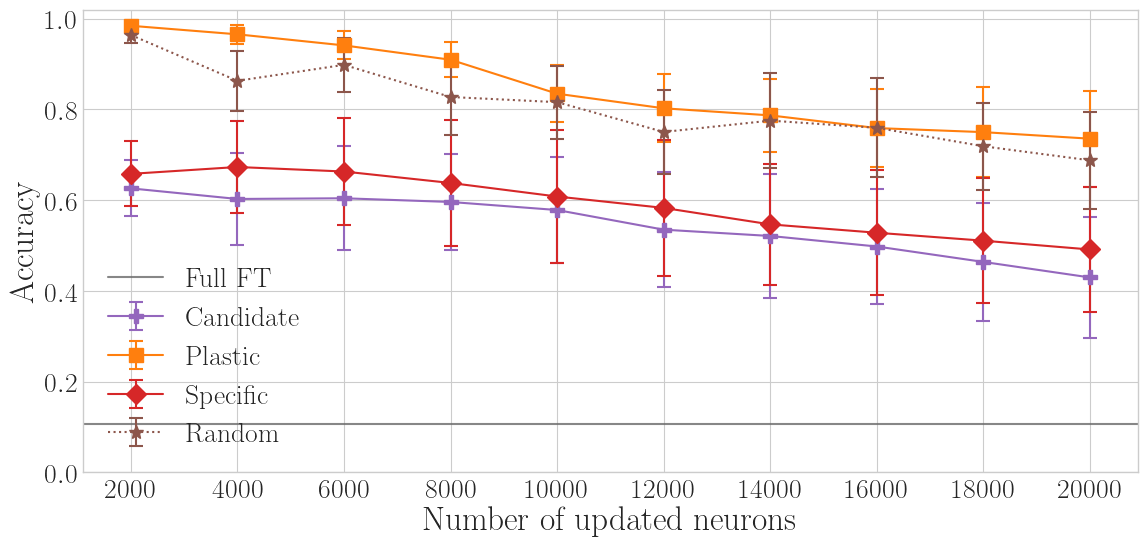

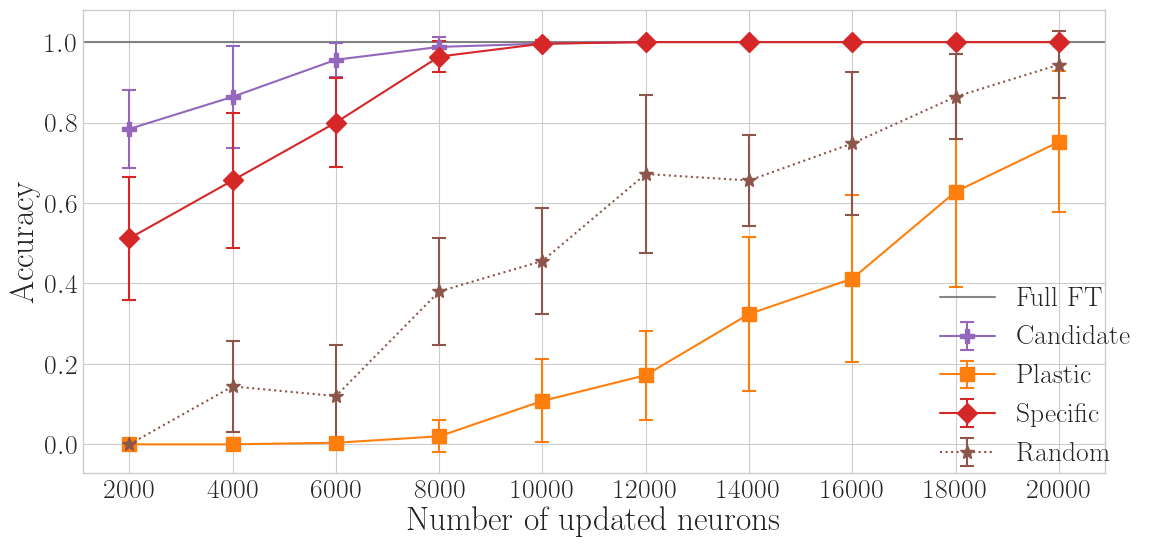

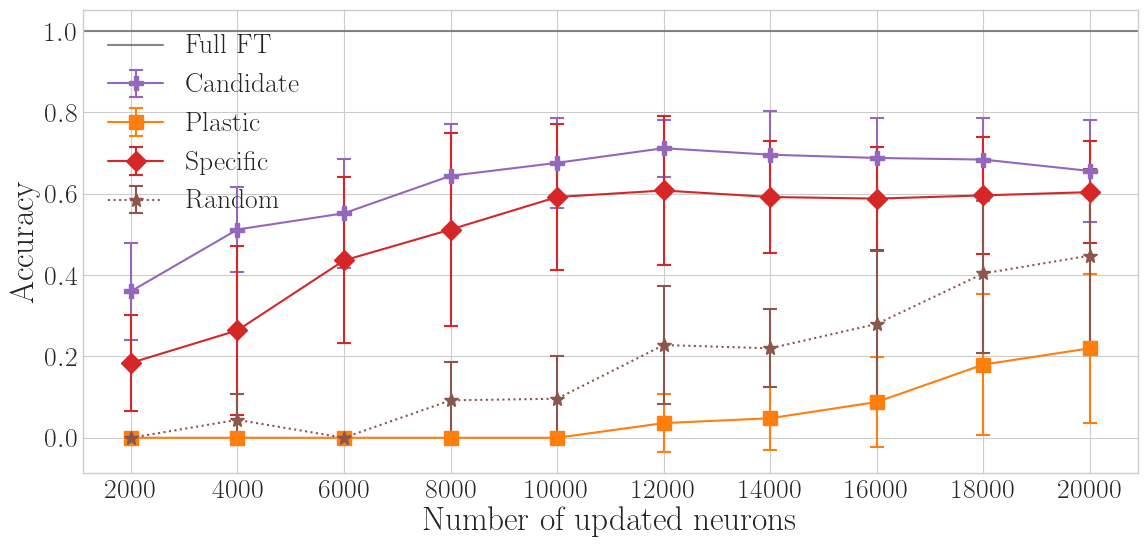

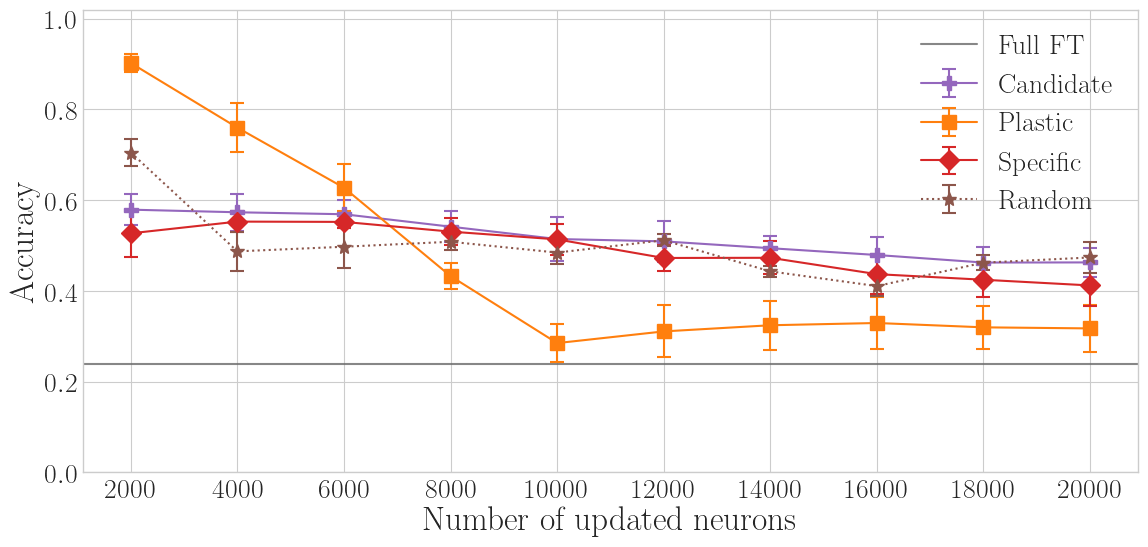

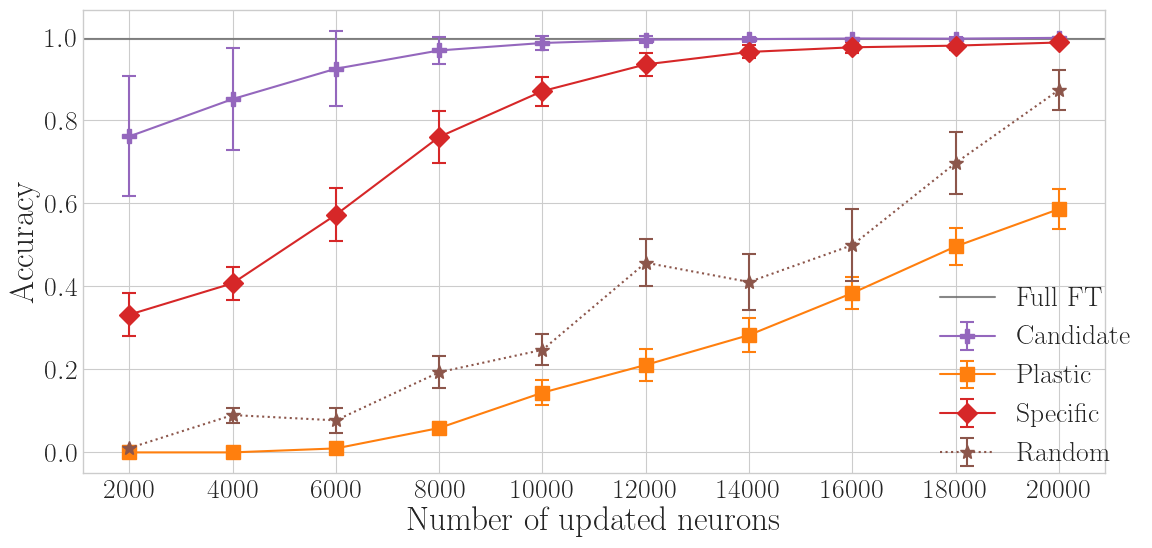

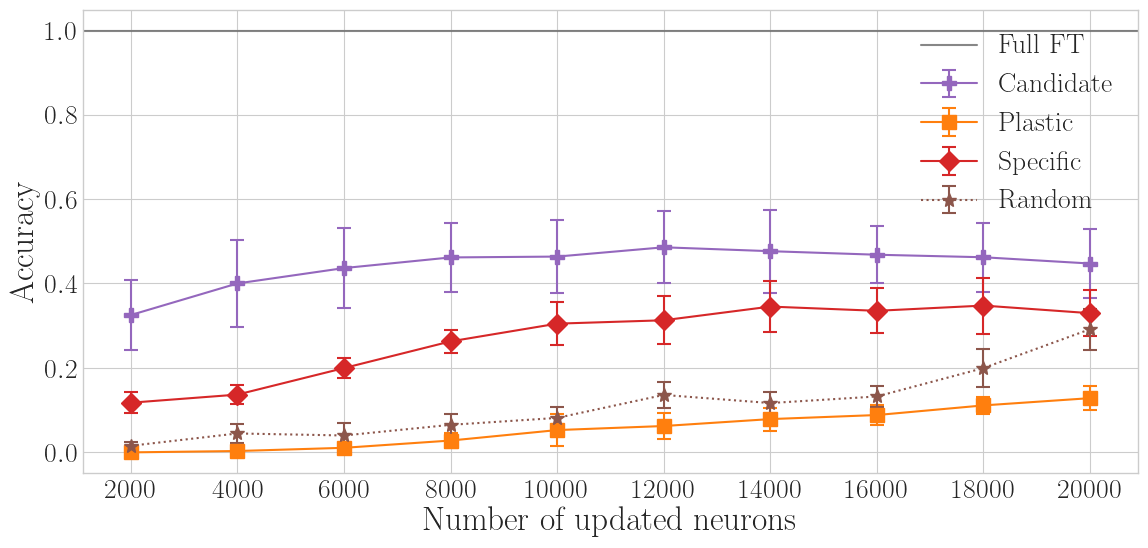

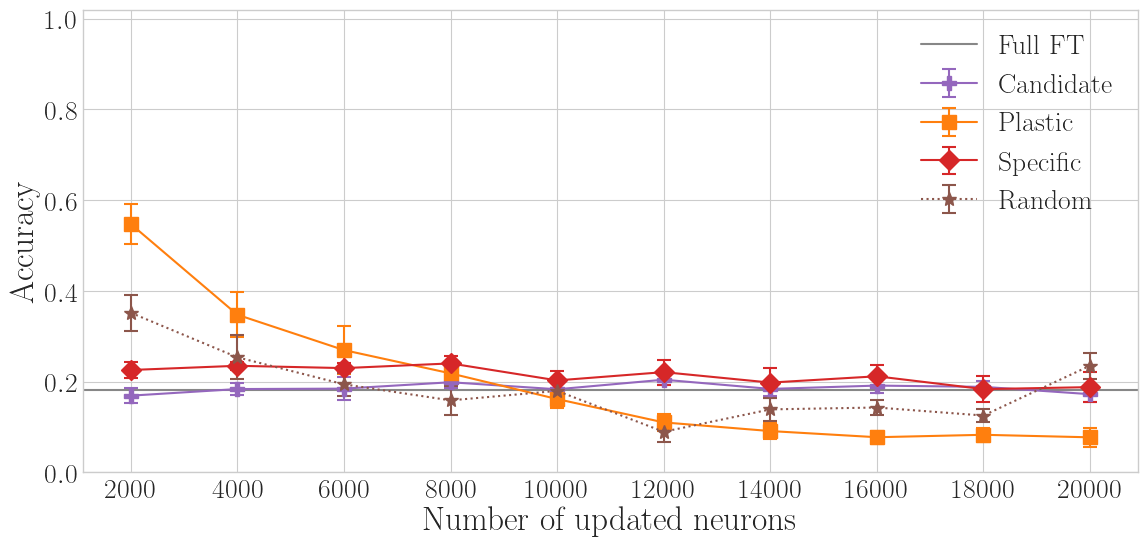

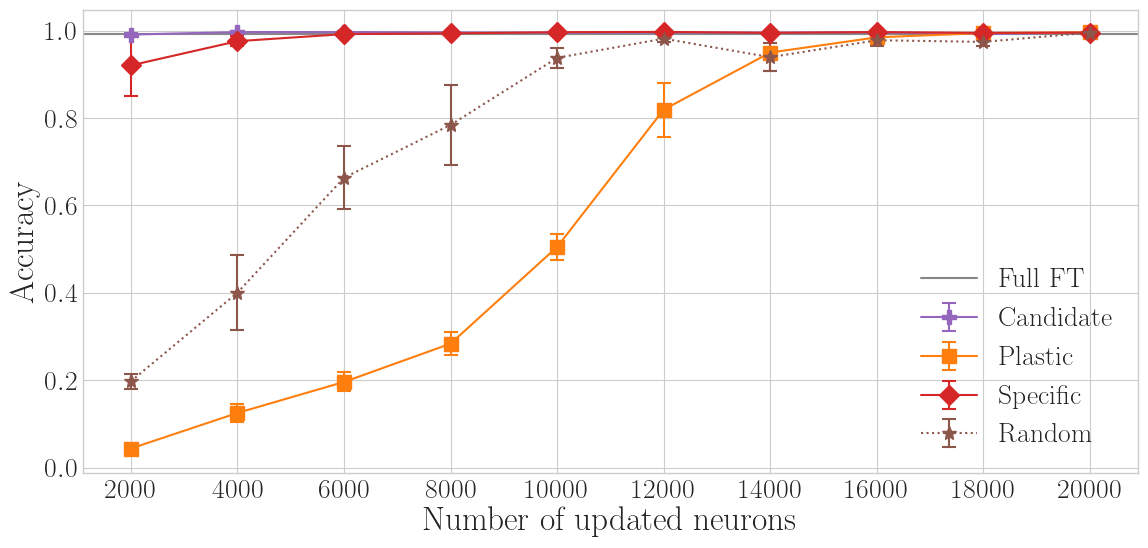

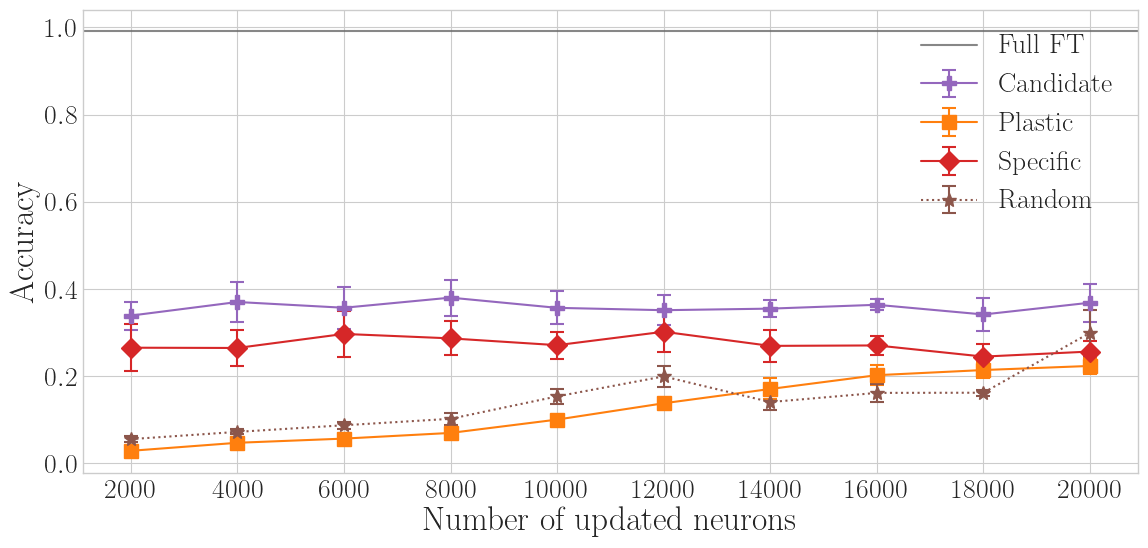

In [19]:
# # N_SAMPLES = 1000
# for N_SAMPLES in [10,100,1000]:
#     experiment_name = 'experiment3_1'
#     filepath = '../results/experiment_3_1/'
#     filename = f'experiment_3_1_2000_{N_SAMPLES}.json'
#     plot_editing_old_new_general(experiment_name, filename, filepath, strategies, loc_old,bbox_old,loc_new, bbox_new, y_lim_old_1, y_lim_old_2)
# Experiment 1 (N_SAMPLES = 10)
experiment_name = 'experiment3_1'
filepath = '../results/experiment_3_1/'

filename = 'experiment_3_1_2000_10.json'
loc_old_1 = 'lower left'
bbox_old_1 = (0, 0)
loc_new_1 = 'lower right'
bbox_new_1 = (1.05, -0.04)
loc_gen_1 = 'upper left'
bbox_gen_1 = (0, 1)
y_lim_old_1_1 = 0
y_lim_old_2_1 = 1.02
plot_editing_old_new_general(experiment_name, filename, filepath, strategies, 
                             loc_old_1, bbox_old_1, loc_new_1, bbox_new_1, loc_gen_1, bbox_gen_1,
                             y_lim_old_1_1, y_lim_old_2_1)

# Experiment 2 (N_SAMPLES = 100)
filename = 'experiment_3_1_2000_100.json'
loc_old_2 = 'upper right'
bbox_old_2 = (1, 1)
loc_new_2 = 'lower right'
bbox_new_2 = (1.05, -0.04)
loc_gen_1 = 'upper right'
bbox_gen_1 = (1, 1)
y_lim_old_1_2 = 0
y_lim_old_2_2 = 1.02
plot_editing_old_new_general(experiment_name, filename, filepath, strategies, 
                             loc_old_2, bbox_old_2, loc_new_2, bbox_new_2, loc_gen_1, bbox_gen_1,
                             y_lim_old_1_2, y_lim_old_2_2)

# Experiment 3 (N_SAMPLES = 1000)
filename = 'experiment_3_1_2000_1000.json'
loc_old_3 = 'upper right'
bbox_old_3 = (1, 1)
loc_new_3 = 'lower right'
bbox_new_3 = (1, 0)
loc_gen_1 = 'upper right'
bbox_gen_1 = (1, 1)
y_lim_old_1_3 = 0
y_lim_old_2_3 = 1.02

plot_editing_old_new_general(experiment_name, filename, filepath, strategies, 
                             loc_old_3, bbox_old_3, loc_new_3, bbox_new_3, loc_gen_1, bbox_gen_1,
                             y_lim_old_1_3, y_lim_old_2_3)

In [8]:
!ls -l ../results/experiment_3_1/experiment_3_1_2000_1000*

-rw-rw-r-- 1 MinnieMouse MinnieMouse 230323 Jul 15 14:03 ../results/experiment_3_1/experiment_3_1_2000_1000_10ep.json
-rw-rw-r-- 1 MinnieMouse MinnieMouse 231677 Jul 15 14:03 ../results/experiment_3_1/experiment_3_1_2000_1000.json


## Print Results for paper

### Full Accuracy table

In [4]:
import json
import numpy as np
from scipy.stats import hmean

def calculate_harmonic_mean(acc_A, acc_B, acc_gen):
    # Check if all values are greater than zero, otherwise return NaN
    if acc_A > 0 and acc_B > 0 and acc_gen > 0:
        return hmean([acc_A, acc_B, acc_gen])
    else:
        return np.nan

def print_results(N_SAMPLES, N_NEURONS):
    with open(f'../results/experiment_3_1/experiment_3_1_2000_{N_SAMPLES}.json', 'r') as file: 
        data = json.load(file)

    results = data['results']

    n_neurons = str(N_NEURONS)

    # Initialize lists to store values for standard deviation and harmonic mean calculations
    ftb_acc_A_list = []
    ftb_acc_B_list = []
    ftb_acc_gen_list = []

    cftb_spec_acc_A_list = []
    cftb_spec_acc_B_list = []
    cftb_spec_acc_gen_list = []

    cftb_freeA_acc_A_list = []
    cftb_freeA_acc_B_list = []
    cftb_freeA_acc_gen_list = []

    cftb_freeB_acc_A_list = []
    cftb_freeB_acc_B_list = []
    cftb_freeB_acc_gen_list = []

    cftb_busyA_acc_A_list = []
    cftb_busyA_acc_B_list = []
    cftb_busyA_acc_gen_list = []

    cftb_busyB_acc_A_list = []
    cftb_busyB_acc_B_list = []
    cftb_busyB_acc_gen_list = []

    cftb_rnd_acc_A_list = []
    cftb_rnd_acc_B_list = []
    cftb_rnd_acc_gen_list = []

    # Lists to store harmonic means for each category
    harmonic_means_ftb = []
    harmonic_means_spec = []
    harmonic_means_freeA = []
    harmonic_means_freeB = []
    harmonic_means_busyA = []
    harmonic_means_busyB = []
    harmonic_means_rnd = []

    for f in results:
        # FT NOT-B
        ftb_acc_A = results[f]['ft-notb']['avg_accA']
        ftb_acc_B = results[f]['ft-notb']['avg_accB']
        ftb_acc_gen = results[f]['ft-notb']['avg_acc_gen']
        
        # Append values to lists for standard deviation calculation
        ftb_acc_A_list.append(ftb_acc_A)
        ftb_acc_B_list.append(ftb_acc_B)
        ftb_acc_gen_list.append(ftb_acc_gen)

        # Calculate harmonic mean for this fold (FT NOT-B)
        harmonic_means_ftb.append(calculate_harmonic_mean(ftb_acc_A, ftb_acc_B, ftb_acc_gen))

        # C-FT NOT-B (spec)
        cftb_spec_acc_A = results[f]['cft-notb'][n_neurons]['spec_B']['avg_accA']
        cftb_spec_acc_B = results[f]['cft-notb'][n_neurons]['spec_B']['avg_accB']
        cftb_spec_acc_gen = results[f]['cft-notb'][n_neurons]['spec_B']['avg_acc_gen']

        cftb_spec_acc_A_list.append(cftb_spec_acc_A)
        cftb_spec_acc_B_list.append(cftb_spec_acc_B)
        cftb_spec_acc_gen_list.append(cftb_spec_acc_gen)

        # Calculate harmonic mean for this fold (C-FT NOT-B spec)
        harmonic_means_spec.append(calculate_harmonic_mean(cftb_spec_acc_A, cftb_spec_acc_B, cftb_spec_acc_gen))

        # C-FT NOT-B (free_A)
        cftb_freeA_acc_A = results[f]['cft-notb'][n_neurons]['free_A']['avg_accA']
        cftb_freeA_acc_B = results[f]['cft-notb'][n_neurons]['free_A']['avg_accB']
        cftb_freeA_acc_gen = results[f]['cft-notb'][n_neurons]['free_A']['avg_acc_gen']

        cftb_freeA_acc_A_list.append(cftb_freeA_acc_A)
        cftb_freeA_acc_B_list.append(cftb_freeA_acc_B)
        cftb_freeA_acc_gen_list.append(cftb_freeA_acc_gen)

        harmonic_means_freeA.append(calculate_harmonic_mean(cftb_freeA_acc_A, cftb_freeA_acc_B, cftb_freeA_acc_gen))

        # C-FT NOT-B (free_B)
        cftb_freeB_acc_A = results[f]['cft-notb'][n_neurons]['free_B']['avg_accA']
        cftb_freeB_acc_B = results[f]['cft-notb'][n_neurons]['free_B']['avg_accB']
        cftb_freeB_acc_gen = results[f]['cft-notb'][n_neurons]['free_B']['avg_acc_gen']

        cftb_freeB_acc_A_list.append(cftb_freeB_acc_A)
        cftb_freeB_acc_B_list.append(cftb_freeB_acc_B)
        cftb_freeB_acc_gen_list.append(cftb_freeB_acc_gen)

        harmonic_means_freeB.append(calculate_harmonic_mean(cftb_freeB_acc_A, cftb_freeB_acc_B, cftb_freeB_acc_gen))

        # C-FT NOT-B (busy_A)
        cftb_busyA_acc_A = results[f]['cft-notb'][n_neurons]['busy_A']['avg_accA']
        cftb_busyA_acc_B = results[f]['cft-notb'][n_neurons]['busy_A']['avg_accB']
        cftb_busyA_acc_gen = results[f]['cft-notb'][n_neurons]['busy_A']['avg_acc_gen']

        cftb_busyA_acc_A_list.append(cftb_busyA_acc_A)
        cftb_busyA_acc_B_list.append(cftb_busyA_acc_B)
        cftb_busyA_acc_gen_list.append(cftb_busyA_acc_gen)

        harmonic_means_busyA.append(calculate_harmonic_mean(cftb_busyA_acc_A, cftb_busyA_acc_B, cftb_busyA_acc_gen))

        # C-FT NOT-B (busy_B)
        cftb_busyB_acc_A = results[f]['cft-notb'][n_neurons]['busy_B']['avg_accA']
        cftb_busyB_acc_B = results[f]['cft-notb'][n_neurons]['busy_B']['avg_accB']
        cftb_busyB_acc_gen = results[f]['cft-notb'][n_neurons]['busy_B']['avg_acc_gen']

        cftb_busyB_acc_A_list.append(cftb_busyB_acc_A)
        cftb_busyB_acc_B_list.append(cftb_busyB_acc_B)
        cftb_busyB_acc_gen_list.append(cftb_busyB_acc_gen)

        harmonic_means_busyB.append(calculate_harmonic_mean(cftb_busyB_acc_A, cftb_busyB_acc_B, cftb_busyB_acc_gen))

        # C-FT NOT-B (rnd)
        cftb_rnd_acc_A = results[f]['cft-notb'][n_neurons]['rnd']['avg_accA']
        cftb_rnd_acc_B = results[f]['cft-notb'][n_neurons]['rnd']['avg_accB']
        cftb_rnd_acc_gen = results[f]['cft-notb'][n_neurons]['rnd']['avg_acc_gen']

        cftb_rnd_acc_A_list.append(cftb_rnd_acc_A)
        cftb_rnd_acc_B_list.append(cftb_rnd_acc_B)
        cftb_rnd_acc_gen_list.append(cftb_rnd_acc_gen)

        harmonic_means_rnd.append(calculate_harmonic_mean(cftb_rnd_acc_A, cftb_rnd_acc_B, cftb_rnd_acc_gen))

    # Calculate standard deviations for each metric
    ftb_acc_A_std = np.std(ftb_acc_A_list)
    ftb_acc_B_std = np.std(ftb_acc_B_list)
    ftb_acc_gen_std = np.std(ftb_acc_gen_list)

    cftb_spec_acc_A_std = np.std(cftb_spec_acc_A_list)
    cftb_spec_acc_B_std = np.std(cftb_spec_acc_B_list)
    cftb_spec_acc_gen_std = np.std(cftb_spec_acc_gen_list)

    cftb_freeA_acc_A_std = np.std(cftb_freeA_acc_A_list)
    cftb_freeA_acc_B_std = np.std(cftb_freeA_acc_B_list)
    cftb_freeA_acc_gen_std = np.std(cftb_freeA_acc_gen_list)

    cftb_freeB_acc_A_std = np.std(cftb_freeB_acc_A_list)
    cftb_freeB_acc_B_std = np.std(cftb_freeB_acc_B_list)
    cftb_freeB_acc_gen_std = np.std(cftb_freeB_acc_gen_list)

    cftb_busyA_acc_A_std = np.std(cftb_busyA_acc_A_list)
    cftb_busyA_acc_B_std = np.std(cftb_busyA_acc_B_list)
    cftb_busyA_acc_gen_std = np.std(cftb_busyA_acc_gen_list)

    cftb_busyB_acc_A_std = np.std(cftb_busyB_acc_A_list)
    cftb_busyB_acc_B_std = np.std(cftb_busyB_acc_B_list)
    cftb_busyB_acc_gen_std = np.std(cftb_busyB_acc_gen_list)

    cftb_rnd_acc_A_std = np.std(cftb_rnd_acc_A_list)
    cftb_rnd_acc_B_std = np.std(cftb_rnd_acc_B_list)
    cftb_rnd_acc_gen_std = np.std(cftb_rnd_acc_gen_list)

    # Calculate standard deviation of harmonic means
    harmonic_mean_ftb_std = np.std([x for x in harmonic_means_ftb if not np.isnan(x)])
    harmonic_mean_spec_std = np.std([x for x in harmonic_means_spec if not np.isnan(x)])
    harmonic_mean_freeA_std = np.std([x for x in harmonic_means_freeA if not np.isnan(x)])
    harmonic_mean_freeB_std = np.std([x for x in harmonic_means_freeB if not np.isnan(x)])
    harmonic_mean_busyA_std = np.std([x for x in harmonic_means_busyA if not np.isnan(x)])
    harmonic_mean_busyB_std = np.std([x for x in harmonic_means_busyB if not np.isnan(x)])
    harmonic_mean_rnd_std = np.std([x for x in harmonic_means_rnd if not np.isnan(x)])

    # Print results (add standard deviations and harmonic means to the output)
    print(f'NUMBER OF NEURONS: {n_neurons} NUMBER of SAMPLES: {N_SAMPLES}')
    print(f"Accuracy FT NOT-B -> A: {np.mean(ftb_acc_A_list):.3f} ± {ftb_acc_A_std:.3f}, "
          f"NOT(B): {np.mean(ftb_acc_B_list):.3f} ± {ftb_acc_B_std:.3f}, "
          f"GEN: {np.mean(ftb_acc_gen_list):.3f} ± {ftb_acc_gen_std:.3f}")
    print(f"Harmonic Mean FT NOT-B -> Mean: {np.nanmean(harmonic_means_ftb):.3f}, "
          f"Std: {harmonic_mean_ftb_std:.3f}")

    print(f"Accuracy C-FT NOT-B (spec) -> A: {np.mean(cftb_spec_acc_A_list):.3f} ± {cftb_spec_acc_A_std:.3f}, "
          f"NOT(B): {np.mean(cftb_spec_acc_B_list):.3f} ± {cftb_spec_acc_B_std:.3f}, "
          f"GEN: {np.mean(cftb_spec_acc_gen_list):.3f} ± {cftb_spec_acc_gen_std:.3f}")
    print(f"Harmonic Mean C-FT NOT-B (spec) -> Mean: {np.nanmean(harmonic_means_spec):.3f}, "
          f"Std: {harmonic_mean_spec_std:.3f}")

    print(f"Accuracy C-FT NOT-B (free_A) -> A: {np.mean(cftb_freeA_acc_A_list):.3f} ± {cftb_freeA_acc_A_std:.3f}, "
          f"NOT(B): {np.mean(cftb_freeA_acc_B_list):.3f} ± {cftb_freeA_acc_B_std:.3f}, "
          f"GEN: {np.mean(cftb_freeA_acc_gen_list):.3f} ± {cftb_freeA_acc_gen_std:.3f}")
    print(f"Harmonic Mean C-FT NOT-B (free_A) -> Mean: {np.nanmean(harmonic_means_freeA):.3f}, "
          f"Std: {harmonic_mean_freeA_std:.3f}")

    print(f"Accuracy C-FT NOT-B (free_B) -> A: {np.mean(cftb_freeB_acc_A_list):.3f} ± {cftb_freeB_acc_A_std:.3f}, "
          f"NOT(B): {np.mean(cftb_freeB_acc_B_list):.3f} ± {cftb_freeB_acc_B_std:.3f}, "
          f"GEN: {np.mean(cftb_freeB_acc_gen_list):.3f} ± {cftb_freeB_acc_gen_std:.3f}")
    print(f"Harmonic Mean C-FT NOT-B (free_B) -> Mean: {np.nanmean(harmonic_means_freeB):.3f}, "
          f"Std: {harmonic_mean_freeB_std:.3f}")

    print(f"Accuracy C-FT NOT-B (busy_A) -> A: {np.mean(cftb_busyA_acc_A_list):.3f} ± {cftb_busyA_acc_A_std:.3f}, "
          f"NOT(B): {np.mean(cftb_busyA_acc_B_list):.3f} ± {cftb_busyA_acc_B_std:.3f}, "
          f"GEN: {np.mean(cftb_busyA_acc_gen_list):.3f} ± {cftb_busyA_acc_gen_std:.3f}")
    print(f"Harmonic Mean C-FT NOT-B (busy_A) -> Mean: {np.nanmean(harmonic_means_busyA):.3f}, "
          f"Std: {harmonic_mean_busyA_std:.3f}")

    print(f"Accuracy C-FT NOT-B (busy_B) -> A: {np.mean(cftb_busyB_acc_A_list):.3f} ± {cftb_busyB_acc_A_std:.3f}, "
          f"NOT(B): {np.mean(cftb_busyB_acc_B_list):.3f} ± {cftb_busyB_acc_B_std:.3f}, "
          f"GEN: {np.mean(cftb_busyB_acc_gen_list):.3f} ± {cftb_busyB_acc_gen_std:.3f}")
    print(f"Harmonic Mean C-FT NOT-B (busy_B) -> Mean: {np.nanmean(harmonic_means_busyB):.3f}, "
          f"Std: {harmonic_mean_busyB_std:.3f}")

    print(f"Accuracy C-FT NOT-B (rnd) -> A: {np.mean(cftb_rnd_acc_A_list):.3f} ± {cftb_rnd_acc_A_std:.3f}, "
          f"NOT(B): {np.mean(cftb_rnd_acc_B_list):.3f} ± {cftb_rnd_acc_B_std:.3f}, "
          f"GEN: {np.mean(cftb_rnd_acc_gen_list):.3f} ± {cftb_rnd_acc_gen_std:.3f}")
    print(f"Harmonic Mean C-FT NOT-B (rnd) -> Mean: {np.nanmean(harmonic_means_rnd):.3f}, "
          f"Std: {harmonic_mean_rnd_std:.3f}")

print('20k neurons----------')
print_results(10, 20000)
print_results(100, 20000)
print_results(1000, 20000)
print('8k neurons----------')
print_results(10, 8000)
print_results(100, 8000)
print_results(1000, 8000)
print('6k neurons----------')
print_results(10, 6000)
print_results(100, 6000)
print_results(1000, 6000)
print('4k neurons----------')
print_results(10, 4000)
print_results(100, 4000)
print_results(1000,4000)

20k neurons----------
NUMBER OF NEURONS: 20000 NUMBER of SAMPLES: 10
Accuracy FT NOT-B -> A: 0.107 ± 0.082, NOT(B): 1.000 ± 0.000, GEN: 0.576 ± 0.117
Harmonic Mean FT NOT-B -> Mean: 0.222, Std: 0.116
Accuracy C-FT NOT-B (spec) -> A: 0.491 ± 0.137, NOT(B): 1.000 ± 0.000, GEN: 0.604 ± 0.126
Harmonic Mean C-FT NOT-B (spec) -> Mean: 0.621, Std: 0.109
Accuracy C-FT NOT-B (free_A) -> A: 0.735 ± 0.105, NOT(B): 0.752 ± 0.175, GEN: 0.220 ± 0.183
Harmonic Mean C-FT NOT-B (free_A) -> Mean: 0.434, Std: 0.185
Accuracy C-FT NOT-B (free_B) -> A: 0.794 ± 0.093, NOT(B): 0.732 ± 0.176, GEN: 0.204 ± 0.169
Harmonic Mean C-FT NOT-B (free_B) -> Mean: 0.424, Std: 0.201
Accuracy C-FT NOT-B (busy_A) -> A: 0.449 ± 0.109, NOT(B): 1.000 ± 0.000, GEN: 0.616 ± 0.091
Harmonic Mean C-FT NOT-B (busy_A) -> Mean: 0.606, Std: 0.084
Accuracy C-FT NOT-B (busy_B) -> A: 0.430 ± 0.134, NOT(B): 1.000 ± 0.000, GEN: 0.656 ± 0.125
Harmonic Mean C-FT NOT-B (busy_B) -> Mean: 0.597, Std: 0.116
Accuracy C-FT NOT-B (rnd) -> A: 0.688 ±

/opt/anaconda/anaconda3/envs/elias/lib/python3.7/site-packages/ipykernel_launcher.py:194: RuntimeWarning: Mean of empty slice
/opt/anaconda/anaconda3/envs/elias/lib/python3.7/site-packages/ipykernel_launcher.py:200: RuntimeWarning: Mean of empty slice
/opt/anaconda/anaconda3/envs/elias/lib/python3.7/site-packages/ipykernel_launcher.py:218: RuntimeWarning: Mean of empty slice


In [17]:
import json
import numpy as np
import pandas as pd
from scipy.stats import hmean
import os

def calculate_harmonic_mean(acc_A, acc_B, acc_gen):
    """
    Calculate the harmonic mean of three accuracy metrics.
    Returns NaN if any of the inputs are non-positive.
    """
    if acc_A > 0 and acc_B > 0 and acc_gen > 0:
        return hmean([acc_A, acc_B, acc_gen])
    else:
        return np.nan

def initialize_lists():
    """
    Initialize all necessary lists to store accuracy metrics and harmonic means.
    """
    return {
        'ft_notb': {'acc_A': [], 'acc_B': [], 'acc_gen': [], 'hmean': []},
        'cftb_spec': {'acc_A': [], 'acc_B': [], 'acc_gen': [], 'hmean': []},
        'cftb_freeA': {'acc_A': [], 'acc_B': [], 'acc_gen': [], 'hmean': []},
        'cftb_freeB': {'acc_A': [], 'acc_B': [], 'acc_gen': [], 'hmean': []},
        'cftb_busyA': {'acc_A': [], 'acc_B': [], 'acc_gen': [], 'hmean': []},
        'cftb_busyB': {'acc_A': [], 'acc_B': [], 'acc_gen': [], 'hmean': []},
        'cftb_rnd': {'acc_A': [], 'acc_B': [], 'acc_gen': [], 'hmean': []},
    }

def process_results(data, n_neurons, metrics):
    """
    Process each fold's results and append to the corresponding lists.
    """
    n_neurons_str = str(n_neurons)

    for f in data['results']:
        # FT NOT-B
        ftb = data['results'][f]['ft-notb']
        ftb_acc_A = ftb['avg_accA']
        ftb_acc_B = ftb['avg_accB']
        ftb_acc_gen = ftb['avg_acc_gen']
        metrics['ft_notb']['acc_A'].append(ftb_acc_A)
        metrics['ft_notb']['acc_B'].append(ftb_acc_B)
        metrics['ft_notb']['acc_gen'].append(ftb_acc_gen)
        metrics['ft_notb']['hmean'].append(calculate_harmonic_mean(ftb_acc_A, ftb_acc_B, ftb_acc_gen))

        # C-FT NOT-B (spec)
        spec = data['results'][f]['cft-notb'][n_neurons_str]['spec_B']
        spec_acc_A = spec['avg_accA']
        spec_acc_B = spec['avg_accB']
        spec_acc_gen = spec['avg_acc_gen']
        metrics['cftb_spec']['acc_A'].append(spec_acc_A)
        metrics['cftb_spec']['acc_B'].append(spec_acc_B)
        metrics['cftb_spec']['acc_gen'].append(spec_acc_gen)
        metrics['cftb_spec']['hmean'].append(calculate_harmonic_mean(spec_acc_A, spec_acc_B, spec_acc_gen))

        # C-FT NOT-B (free_A)
        freeA = data['results'][f]['cft-notb'][n_neurons_str]['free_A']
        freeA_acc_A = freeA['avg_accA']
        freeA_acc_B = freeA['avg_accB']
        freeA_acc_gen = freeA['avg_acc_gen']
        metrics['cftb_freeA']['acc_A'].append(freeA_acc_A)
        metrics['cftb_freeA']['acc_B'].append(freeA_acc_B)
        metrics['cftb_freeA']['acc_gen'].append(freeA_acc_gen)
        metrics['cftb_freeA']['hmean'].append(calculate_harmonic_mean(freeA_acc_A, freeA_acc_B, freeA_acc_gen))

        # C-FT NOT-B (free_B)
        freeB = data['results'][f]['cft-notb'][n_neurons_str]['free_B']
        freeB_acc_A = freeB['avg_accA']
        freeB_acc_B = freeB['avg_accB']
        freeB_acc_gen = freeB['avg_acc_gen']
        metrics['cftb_freeB']['acc_A'].append(freeB_acc_A)
        metrics['cftb_freeB']['acc_B'].append(freeB_acc_B)
        metrics['cftb_freeB']['acc_gen'].append(freeB_acc_gen)
        metrics['cftb_freeB']['hmean'].append(calculate_harmonic_mean(freeB_acc_A, freeB_acc_B, freeB_acc_gen))

        # C-FT NOT-B (busy_A)
        busyA = data['results'][f]['cft-notb'][n_neurons_str]['busy_A']
        busyA_acc_A = busyA['avg_accA']
        busyA_acc_B = busyA['avg_accB']
        busyA_acc_gen = busyA['avg_acc_gen']
        metrics['cftb_busyA']['acc_A'].append(busyA_acc_A)
        metrics['cftb_busyA']['acc_B'].append(busyA_acc_B)
        metrics['cftb_busyA']['acc_gen'].append(busyA_acc_gen)
        metrics['cftb_busyA']['hmean'].append(calculate_harmonic_mean(busyA_acc_A, busyA_acc_B, busyA_acc_gen))

        # C-FT NOT-B (busy_B)
        busyB = data['results'][f]['cft-notb'][n_neurons_str]['busy_B']
        busyB_acc_A = busyB['avg_accA']
        busyB_acc_B = busyB['avg_accB']
        busyB_acc_gen = busyB['avg_acc_gen']
        metrics['cftb_busyB']['acc_A'].append(busyB_acc_A)
        metrics['cftb_busyB']['acc_B'].append(busyB_acc_B)
        metrics['cftb_busyB']['acc_gen'].append(busyB_acc_gen)
        metrics['cftb_busyB']['hmean'].append(calculate_harmonic_mean(busyB_acc_A, busyB_acc_B, busyB_acc_gen))

        # C-FT NOT-B (rnd)
        rnd = data['results'][f]['cft-notb'][n_neurons_str]['rnd']
        rnd_acc_A = rnd['avg_accA']
        rnd_acc_B = rnd['avg_accB']
        rnd_acc_gen = rnd['avg_acc_gen']
        metrics['cftb_rnd']['acc_A'].append(rnd_acc_A)
        metrics['cftb_rnd']['acc_B'].append(rnd_acc_B)
        metrics['cftb_rnd']['acc_gen'].append(rnd_acc_gen)
        metrics['cftb_rnd']['hmean'].append(calculate_harmonic_mean(rnd_acc_A, rnd_acc_B, rnd_acc_gen))

def compute_statistics(metrics):
    """
    Compute mean and standard deviation for each metric.
    """
    stats = {}
    for key, submetrics in metrics.items():
        stats[key] = {}
        for metric, values in submetrics.items():
            if metric != 'hmean':
                mean = np.mean(values)
                std = np.std(values)
                stats[key][f'{metric}_mean'] = mean
                stats[key][f'{metric}_std'] = std
            else:
                # For harmonic mean, exclude NaN values
                valid_values = [x for x in values if not np.isnan(x)]
                mean = np.nanmean(valid_values)
                std = np.std(valid_values)
                stats[key][f'{metric}_mean'] = mean
                stats[key][f'{metric}_std'] = std
    return stats

def print_statistics(n_neurons, n_samples, stats):
    """
    Print the statistics in a formatted manner.
    """
    print(f'NUMBER OF NEURONS: {n_neurons} NUMBER of SAMPLES: {n_samples}')
    
    def print_strategy(strategy_name, strategy_stats):
        print(f"Accuracy {strategy_name} -> A: {strategy_stats['acc_A_mean']:.3f} ± {strategy_stats['acc_A_std']:.3f}, "
              f"NOT(B): {strategy_stats['acc_B_mean']:.3f} ± {strategy_stats['acc_B_std']:.3f}, "
              f"GEN: {strategy_stats['acc_gen_mean']:.3f} ± {strategy_stats['acc_gen_std']:.3f}")
        print(f"Harmonic Mean {strategy_name} -> Mean: {strategy_stats['hmean_mean']:.3f}, "
              f"Std: {strategy_stats['hmean_std']:.3f}")
    
    strategy_mapping = {
        'ft_notb': 'FT NOT-B',
        'cftb_spec': 'C-FT NOT-B (spec)',
        'cftb_freeA': 'C-FT NOT-B (free_A)',
        'cftb_freeB': 'C-FT NOT-B (free_B)',
        'cftb_busyA': 'C-FT NOT-B (busy_A)',
        'cftb_busyB': 'C-FT NOT-B (busy_B)',
        'cftb_rnd': 'C-FT NOT-B (rnd)'
    }
    
    for key in strategy_mapping:
        print_strategy(strategy_mapping[key], stats[key])
        print()  # Add an empty line for better readability

def generate_latex_table(n_neurons, results_df, output_dir):
    """
    Generate a LaTeX table for the given number of neurons.
    """
    strategies = {
        'FT NOT-B': 'ft_notb',
        'C-FT NOT-B (spec)': 'cftb_spec',
        'C-FT NOT-B (free_A)': 'cftb_freeA',
        'C-FT NOT-B (free_B)': 'cftb_freeB',
        'C-FT NOT-B (busy_A)': 'cftb_busyA',
        'C-FT NOT-B (busy_B)': 'cftb_busyB',
        'C-FT NOT-B (rnd)': 'cftb_rnd'
    }
    
    # Filter DataFrame for the current number of neurons
    df_neurons = results_df[results_df['N_NEURONS'] == n_neurons]
    
    # Initialize LaTeX table string
    table_str = f"""\\begin{{table}}[h]
\\centering
\\caption{{Neuron Editing Results for N={n_neurons:,} Neurons}}
\\label{{tab:neuron_editing_{n_neurons}}}
\\resizebox{{\\textwidth}}{{!}}{{%
\\begin{{tabular}}{{cccccc}}
\\toprule
\\textbf{{Samples}} & \\textbf{{Strategy}} & \\textbf{{Accuracy A}} & \\textbf{{Accuracy NOT(B)}} & \\textbf{{Accuracy GEN}} & \\textbf{{Harmonic Mean}} \\\\
\\midrule
"""

    for n_samples in sorted(df_neurons['N_SAMPLES'].unique()):
        df_samples = df_neurons[df_neurons['N_SAMPLES'] == n_samples]
        table_str += f"\\multirow{{{len(strategies)}}}{{*}}{{{n_samples}}} \\\\ \n"
        for idx, (strategy_name, strategy_key) in enumerate(strategies.items()):
            row = df_samples[df_samples['Strategy'] == strategy_name].iloc[0]
            acc_a = f"{row['Accuracy_A']:.3f} ({row['Accuracy_A_std']:.3f})"
            acc_notb = f"{row['Accuracy_NOTB']:.3f} ({row['Accuracy_NOTB_std']:.3f})"
            acc_gen = f"{row['Accuracy_GEN']:.3f} ({row['Accuracy_GEN_std']:.3f})"
            hmean = f"{row['Harmonic_Mean']:.3f} ({row['Harmonic_Mean_std']:.3f})" if not np.isnan(row['Harmonic_Mean']) else "nan"
            if idx == 0:
                table_str += f" & {strategy_name:<25} & {acc_a} & {acc_notb} & {acc_gen} & {hmean} \\\\ \n"
            else:
                table_str += f" & {strategy_name:<25} & {acc_a} & {acc_notb} & {acc_gen} & {hmean} \\\\ \n"
        table_str += "\\midrule\n"

    # Remove the last \midrule and add \bottomrule
    table_str = table_str.rstrip("\\midrule\n") + "\\bottomrule\n"

    table_str += """\\end{tabular}
}
\\end{table}
"""

    # Define the output file path
    latex_filename = f"neuron_editing_{n_neurons}.tex"
    latex_filepath = os.path.join(output_dir, latex_filename)

    # Write the LaTeX table to the file
    with open(latex_filepath, 'w') as f:
        f.write(table_str)
    print(f"LaTeX table for {n_neurons} neurons written to {latex_filepath}")

def print_results(N_SAMPLES, N_NEURONS, aggregated_results):
    """
    Process the results for given N_SAMPLES and N_NEURONS,
    compute statistics, and store them for further use.
    """
    # Path to the JSON file
    json_path = f'../results/experiment_3_1/experiment_3_1_2000_{N_SAMPLES}.json'
    
    # Load the JSON data
    with open(json_path, 'r') as file: 
        data = json.load(file)
    
    # Initialize metrics storage
    metrics = initialize_lists()
    
    # Process each fold and collect metrics
    process_results(data, N_NEURONS, metrics)
    
    # Compute statistics
    stats = compute_statistics(metrics)
    
    # Print statistics
    print_statistics(N_NEURONS, N_SAMPLES, stats)
    
    # Store the statistics in aggregated_results
    strategy_mapping = {
        'ft_notb': 'FT NOT-B',
        'cftb_spec': 'C-FT NOT-B (spec)',
        'cftb_freeA': 'C-FT NOT-B (free_A)',
        'cftb_freeB': 'C-FT NOT-B (free_B)',
        'cftb_busyA': 'C-FT NOT-B (busy_A)',
        'cftb_busyB': 'C-FT NOT-B (busy_B)',
        'cftb_rnd': 'C-FT NOT-B (rnd)'
    }
    
    for key, strategy_name in strategy_mapping.items():
        aggregated_results.append({
            'N_SAMPLES': N_SAMPLES,
            'N_NEURONS': N_NEURONS,
            'Strategy': strategy_name,
            'Accuracy_A': stats[key]['acc_A_mean'],
            'Accuracy_A_std': stats[key]['acc_A_std'],
            'Accuracy_NOTB': stats[key]['acc_B_mean'],
            'Accuracy_NOTB_std': stats[key]['acc_B_std'],
            'Accuracy_GEN': stats[key]['acc_gen_mean'],
            'Accuracy_GEN_std': stats[key]['acc_gen_std'],
            'Harmonic_Mean': stats[key]['hmean_mean'],
            'Harmonic_Mean_std': stats[key]['hmean_std']
        })

def main():
    # Define the output directory
    output_dir = '/home/MinnieMouse/project/epmem_edit/experiments/gpt2-small/experiment_3_1/results'
    
    # Create the directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize a list to collect all results
    aggregated_results = []
    
    # Define the configurations to process
    configurations = [
        ('20k neurons', 20000),
        ('8k neurons', 8000),
        ('6k neurons', 6000),
        ('4k neurons', 4000)  # Assuming '4k neurons' should correspond to 4000
    ]
    
    # Define the sample sizes
    sample_sizes = [10, 100, 1000]
    
    # Iterate over each configuration and sample size
    for label, n_neurons in configurations:
        print(f'\n{label}----------')
        for n_samples in sample_sizes:
            print_results(n_samples, n_neurons, aggregated_results)
    
    # Convert the aggregated results to a DataFrame
    results_df = pd.DataFrame(aggregated_results)
    
    # Define the JSON and CSV file paths
    json_output_path = os.path.join(output_dir, 'aggregated_results.json')
    csv_output_path = os.path.join(output_dir, 'aggregated_results.csv')
    
    # Save the results to JSON
    with open(json_output_path, 'w') as f_json:
        json.dump(aggregated_results, f_json, indent=4)
    print(f"\nAggregated results written to {json_output_path}")
    
    # Save the results to CSV
    results_df.to_csv(csv_output_path, index=False)
    print(f"Aggregated results written to {csv_output_path}")
    
    # Generate LaTeX tables for each number of neurons
    for n_neurons in results_df['N_NEURONS'].unique():
        generate_latex_table(n_neurons, results_df, output_dir)

if __name__ == "__main__":
    main()


20k neurons----------
NUMBER OF NEURONS: 20000 NUMBER of SAMPLES: 10
Accuracy FT NOT-B -> A: 0.107 ± 0.082, NOT(B): 1.000 ± 0.000, GEN: 0.576 ± 0.117
Harmonic Mean FT NOT-B -> Mean: 0.222, Std: 0.116

Accuracy C-FT NOT-B (spec) -> A: 0.491 ± 0.137, NOT(B): 1.000 ± 0.000, GEN: 0.604 ± 0.126
Harmonic Mean C-FT NOT-B (spec) -> Mean: 0.621, Std: 0.109

Accuracy C-FT NOT-B (free_A) -> A: 0.735 ± 0.105, NOT(B): 0.752 ± 0.175, GEN: 0.220 ± 0.183
Harmonic Mean C-FT NOT-B (free_A) -> Mean: 0.434, Std: 0.185

Accuracy C-FT NOT-B (free_B) -> A: 0.794 ± 0.093, NOT(B): 0.732 ± 0.176, GEN: 0.204 ± 0.169
Harmonic Mean C-FT NOT-B (free_B) -> Mean: 0.424, Std: 0.201

Accuracy C-FT NOT-B (busy_A) -> A: 0.449 ± 0.109, NOT(B): 1.000 ± 0.000, GEN: 0.616 ± 0.091
Harmonic Mean C-FT NOT-B (busy_A) -> Mean: 0.606, Std: 0.084

Accuracy C-FT NOT-B (busy_B) -> A: 0.430 ± 0.134, NOT(B): 1.000 ± 0.000, GEN: 0.656 ± 0.125
Harmonic Mean C-FT NOT-B (busy_B) -> Mean: 0.597, Std: 0.116

Accuracy C-FT NOT-B (rnd) -> A: 

/opt/anaconda/anaconda3/envs/elias/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: Mean of empty slice
/opt/anaconda/anaconda3/envs/elias/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/opt/anaconda/anaconda3/envs/elias/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/opt/anaconda/anaconda3/envs/elias/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Old Plots
### Accuracy plot

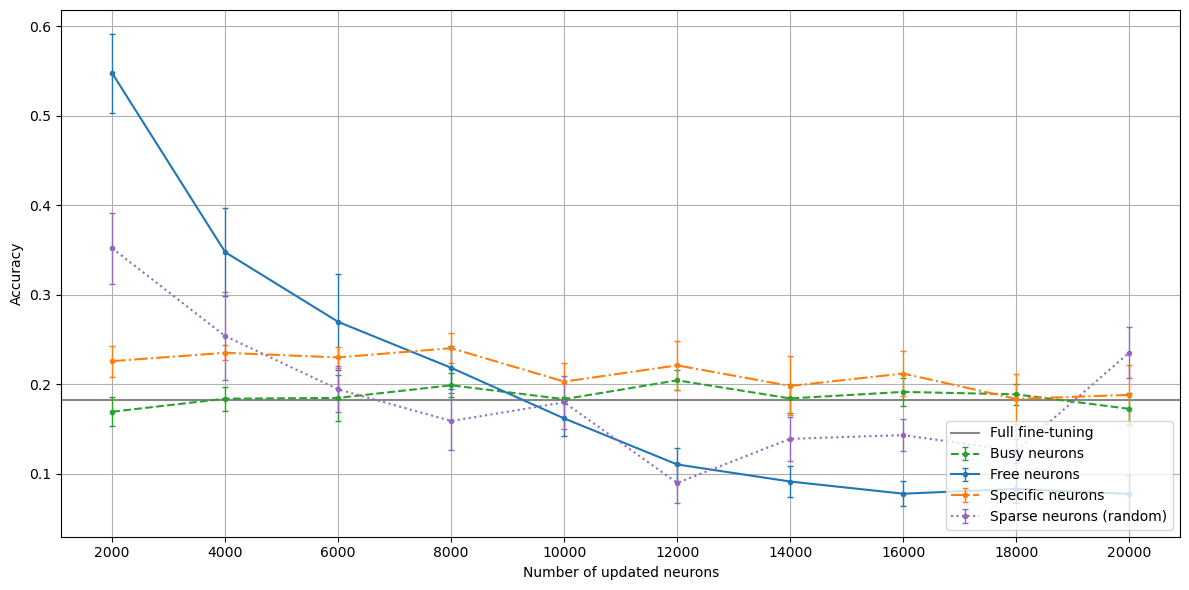

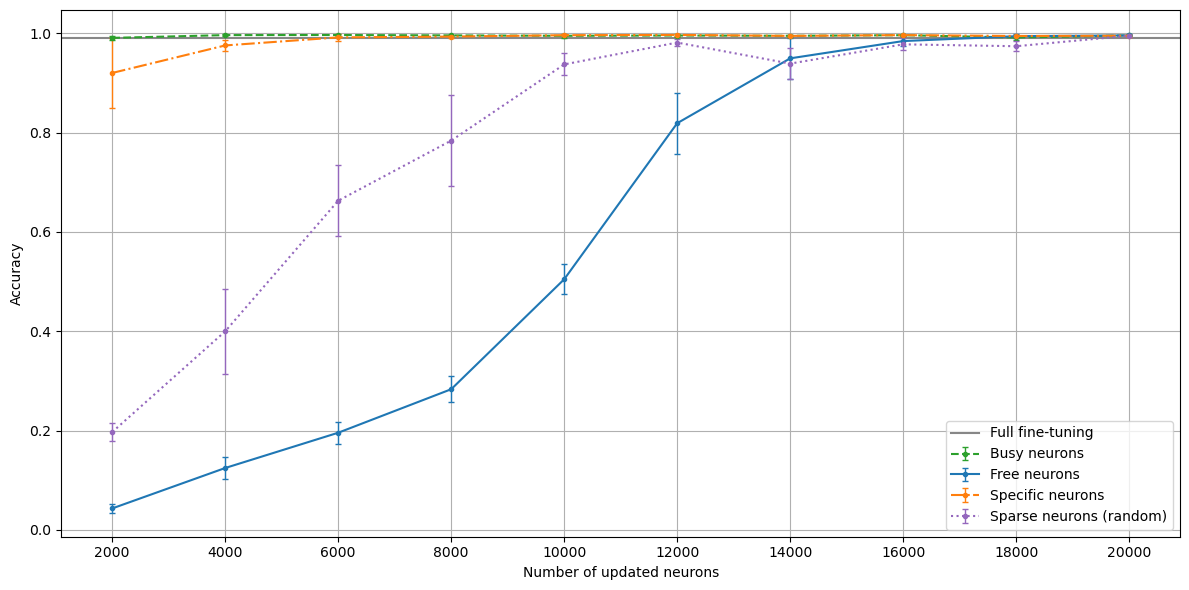

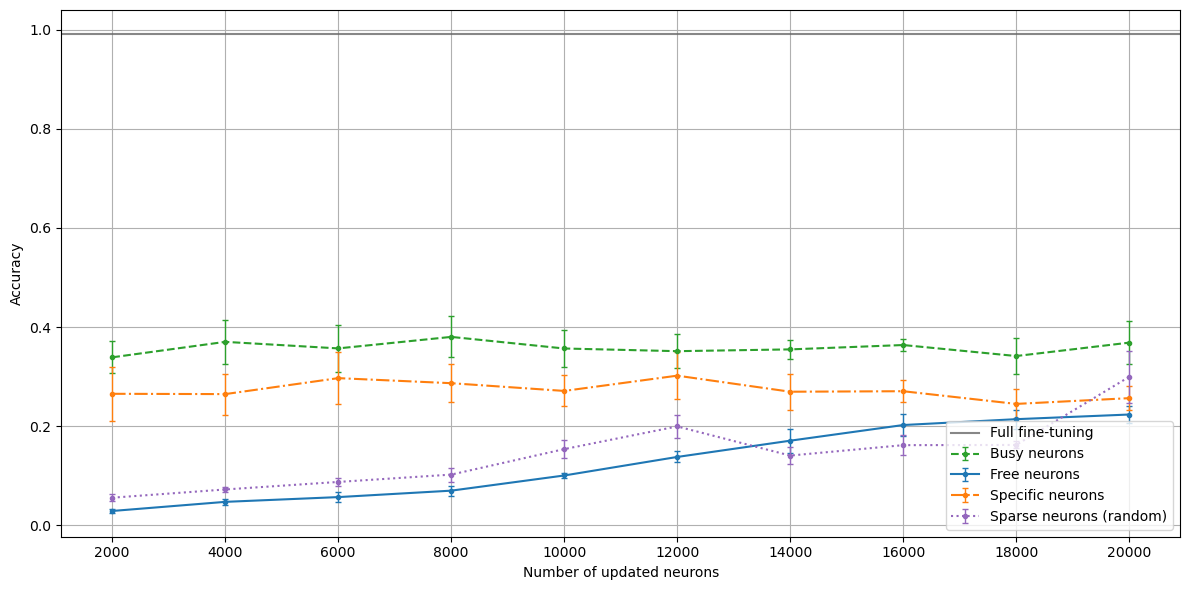

In [3]:
import numpy as np
import matplotlib.pyplot as plt

N_SAMPLES = 1000

with open(f'../results/experiment_3_1/experiment_3_1_2000_{N_SAMPLES}.json', 'r') as file: 
    data = json.load(file)

results = data['results']

n_folds =  len(data['results'].keys())
n_thresh = len(list(data['results'].values())[0]['cft-notb'].keys())

fta_accA = 0

ftb_accA = 0
ftb_accB = 0
ftb_acc_gen = 0

# Arrays to store individual fold results for calculating std dev
fold_results_cftb_busyA_accA = np.zeros((n_folds, n_thresh))
fold_results_cftb_busyA_accB = np.zeros((n_folds, n_thresh))
fold_results_cftb_busyA_gen = np.zeros((n_folds, n_thresh))

fold_results_cftb_freeA_accA = np.zeros((n_folds, n_thresh))
fold_results_cftb_freeA_accB = np.zeros((n_folds, n_thresh))
fold_results_cftb_freeA_gen = np.zeros((n_folds, n_thresh))

fold_results_cftb_busyB_accA = np.zeros((n_folds, n_thresh))
fold_results_cftb_busyB_accB = np.zeros((n_folds, n_thresh))
fold_results_cftb_busyB_gen = np.zeros((n_folds, n_thresh))

fold_results_cftb_freeB_accA = np.zeros((n_folds, n_thresh))
fold_results_cftb_freeB_accB = np.zeros((n_folds, n_thresh))
fold_results_cftb_freeB_gen = np.zeros((n_folds, n_thresh))

fold_results_cftb_specB_accA = np.zeros((n_folds, n_thresh))
fold_results_cftb_specB_accB = np.zeros((n_folds, n_thresh))
fold_results_cftb_specB_gen = np.zeros((n_folds, n_thresh))

fold_results_cftb_rnd_accA = np.zeros((n_folds, n_thresh))
fold_results_cftb_rnd_accB = np.zeros((n_folds, n_thresh))
fold_results_cftb_rnd_gen = np.zeros((n_folds, n_thresh))

for i, fold in enumerate(data['results']):

    ftb_accA += data['results'][fold]['ft-notb']['avg_accA']
    ftb_accB += data['results'][fold]['ft-notb']['avg_accB']

    cftb_results = data['results'][fold]['cft-notb']

    fold_results_cftb_busyA_accA[i, :] = np.array([cftb_results[t]['busy_A']['avg_accA'] for t in cftb_results]).astype(float)
    fold_results_cftb_busyA_accB[i, :] = np.array([cftb_results[t]['busy_A']['avg_accB'] for t in cftb_results]).astype(float)
    fold_results_cftb_busyA_gen[i, :] = np.array([cftb_results[t]['busy_A']['avg_acc_gen'] for t in cftb_results]).astype(float)

    fold_results_cftb_busyB_accA[i, :] = np.array([cftb_results[t]['busy_B']['avg_accA'] for t in cftb_results]).astype(float)
    fold_results_cftb_busyB_accB[i, :] = np.array([cftb_results[t]['busy_B']['avg_accB'] for t in cftb_results]).astype(float)
    fold_results_cftb_busyB_gen[i, :] = np.array([cftb_results[t]['busy_B']['avg_acc_gen'] for t in cftb_results]).astype(float)

    fold_results_cftb_freeA_accA[i, :] = np.array([cftb_results[t]['free_A']['avg_accA'] for t in cftb_results]).astype(float)
    fold_results_cftb_freeA_accB[i, :] = np.array([cftb_results[t]['free_A']['avg_accB'] for t in cftb_results]).astype(float)
    fold_results_cftb_freeA_gen[i, :] = np.array([cftb_results[t]['free_A']['avg_acc_gen'] for t in cftb_results]).astype(float)

    fold_results_cftb_freeB_accA[i, :] = np.array([cftb_results[t]['free_B']['avg_accA'] for t in cftb_results]).astype(float)
    fold_results_cftb_freeB_accB[i, :] = np.array([cftb_results[t]['free_B']['avg_accB'] for t in cftb_results]).astype(float)
    fold_results_cftb_freeB_gen[i, :] = np.array([cftb_results[t]['free_B']['avg_acc_gen'] for t in cftb_results]).astype(float)

    fold_results_cftb_specB_accA[i, :] = np.array([cftb_results[t]['spec_B']['avg_accA'] for t in cftb_results]).astype(float)
    fold_results_cftb_specB_accB[i, :] = np.array([cftb_results[t]['spec_B']['avg_accB'] for t in cftb_results]).astype(float)
    fold_results_cftb_specB_gen[i, :] = np.array([cftb_results[t]['spec_B']['avg_acc_gen'] for t in cftb_results]).astype(float)

    fold_results_cftb_rnd_accA[i, :] = np.array([cftb_results[t]['rnd']['avg_accA'] for t in cftb_results]).astype(float)
    fold_results_cftb_rnd_accB[i, :] = np.array([cftb_results[t]['rnd']['avg_accB'] for t in cftb_results]).astype(float)
    fold_results_cftb_rnd_gen[i, :] = np.array([cftb_results[t]['rnd']['avg_acc_gen'] for t in cftb_results]).astype(float)

fta_accA /= n_folds
ftb_accA /= n_folds
ftb_accB /= n_folds

cftb_freeA_accA = np.mean(fold_results_cftb_freeA_accA, axis=0)
cftb_freeA_accB = np.mean(fold_results_cftb_freeA_accB, axis=0)
cftb_freeA_gen = np.mean(fold_results_cftb_freeA_gen, axis=0)

cftb_freeB_accA = np.mean(fold_results_cftb_freeB_accA, axis=0)
cftb_freeB_accB = np.mean(fold_results_cftb_freeB_accB, axis=0)
cftb_freeB_gen = np.mean(fold_results_cftb_freeB_gen, axis=0)

cftb_busyA_accA = np.mean(fold_results_cftb_busyA_accA, axis=0)
cftb_busyA_accB = np.mean(fold_results_cftb_busyA_accB, axis=0)
cftb_busyA_gen = np.mean(fold_results_cftb_busyA_gen, axis=0)

cftb_busyB_accA = np.mean(fold_results_cftb_busyB_accA, axis=0)
cftb_busyB_accB = np.mean(fold_results_cftb_busyB_accB, axis=0)
cftb_busyB_gen = np.mean(fold_results_cftb_busyB_gen, axis=0)

cftb_specB_accA = np.mean(fold_results_cftb_specB_accA, axis=0)
cftb_specB_accB = np.mean(fold_results_cftb_specB_accB, axis=0)
cftb_specB_gen = np.mean(fold_results_cftb_specB_gen, axis=0)

cftb_rnd_accA = np.mean(fold_results_cftb_rnd_accA, axis=0)
cftb_rnd_accB = np.mean(fold_results_cftb_rnd_accB, axis=0)
cftb_rnd_gen = np.mean(fold_results_cftb_rnd_gen, axis=0)

# Calculate standard deviation
std_cftb_freeA_accA = np.std(fold_results_cftb_freeA_accA, axis=0)
std_cftb_freeA_accB = np.std(fold_results_cftb_freeA_accB, axis=0)
std_cftb_freeA_gen = np.std(fold_results_cftb_freeA_gen, axis=0)

std_cftb_freeB_accA = np.std(fold_results_cftb_freeB_accA, axis=0)
std_cftb_freeB_accB = np.std(fold_results_cftb_freeB_accB, axis=0)
std_cftb_freeB_gen = np.std(fold_results_cftb_freeB_gen, axis=0)

std_cftb_busyA_accA = np.std(fold_results_cftb_busyA_accA, axis=0)
std_cftb_busyA_accB = np.std(fold_results_cftb_busyA_accB, axis=0)
std_cftb_busyA_gen = np.std(fold_results_cftb_busyA_gen, axis=0)

std_cftb_busyB_accA = np.std(fold_results_cftb_busyB_accA, axis=0)
std_cftb_busyB_accB = np.std(fold_results_cftb_busyB_accB, axis=0)
std_cftb_busyB_gen = np.std(fold_results_cftb_busyB_gen, axis=0)

std_cftb_specB_accA = np.std(fold_results_cftb_specB_accA, axis=0)
std_cftb_specB_accB = np.std(fold_results_cftb_specB_accB, axis=0)
std_cftb_specB_gen = np.std(fold_results_cftb_specB_gen, axis=0)

std_cftb_rnd_accA = np.std(fold_results_cftb_rnd_accA, axis=0)
std_cftb_rnd_accB = np.std(fold_results_cftb_rnd_accB, axis=0)
std_cftb_rnd_gen = np.std(fold_results_cftb_rnd_gen, axis=0)

fig, axs = plt.subplots(1, 1, figsize=(12, 6))

# Creating custom x labels
x_labels = list(cftb_results.keys())

# First subplot
# axs.axhline(y=fta_accA, color='firebrick', linestyle='solid', linewidth=1.5, alpha=0.80, label='Initial')
axs.axhline(y=ftb_accA, color='dimgrey', linestyle='solid', linewidth=1.5, alpha=0.80, label='Full FT')
axs.errorbar(x_labels, cftb_busyB_accA, yerr=std_cftb_busyB_accA, linestyle='--', linewidth=1.5, color='tab:green', marker='.', linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5, label='Busy neurons')
axs.errorbar(x_labels, cftb_freeA_accA, yerr=std_cftb_freeA_accA, linestyle='-', linewidth=1.5, color='tab:blue', marker='.', linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5, label='Free neurons')
axs.errorbar(x_labels, cftb_specB_accA, yerr=std_cftb_specB_accA, linestyle='-.',linewidth=1.5, color='tab:orange', marker='.', linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5, label='Specific neurons')
axs.errorbar(x_labels, cftb_rnd_accA, yerr=std_cftb_rnd_accA, linestyle=':', linewidth=1.5, color='tab:purple', marker='.', linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5, label='Sparse neurons (random)')
axs.set_xlabel('Number of updated neurons')
axs.set_ylabel('Accuracy')
#axs.set_title('Sequential learning experiment - Accuracy of Previous Knowledge')
axs.legend(loc='lower right')
axs.grid(True)

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(12, 6))

# Second subplot
axs.axhline(y=ftb_accB, color='dimgrey', linestyle='solid', linewidth=1.5, alpha=0.80, label='Full FT')
axs.errorbar(x_labels, cftb_busyB_accB, yerr=std_cftb_busyB_accB, linestyle='--', linewidth=1.5, color='tab:green', marker='.', linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5, label='Busy neurons')
axs.errorbar(x_labels, cftb_freeA_accB, yerr=std_cftb_freeA_accB, linestyle='-', linewidth=1.5, color='tab:blue', marker='.', linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5, label='Free neurons')
axs.errorbar(x_labels, cftb_specB_accB, yerr=std_cftb_specB_accB, linestyle='-.', linewidth=1.5, color='tab:orange', marker='.', linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5, label='Specific neurons')
axs.errorbar(x_labels, cftb_rnd_accB, yerr=std_cftb_rnd_accB, linestyle=':', linewidth=1.5, color='tab:purple', marker='.', linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5, label='Sparse neurons (random)')
axs.set_xlabel('Number of updated neurons')
axs.set_ylabel('Accuracy')
#axs.set_title('Sequential learning experiment - Accuracy of New Knowledge')
axs.legend(loc='lower right')
axs.grid(True)

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(12, 6))

# Third subplot
axs.axhline(y=ftb_accB, color='dimgrey', linestyle='solid', linewidth=1.5, alpha=0.80, label='Full FT')
axs.errorbar(x_labels, cftb_busyB_gen, yerr=std_cftb_busyB_gen, linestyle='--', linewidth=1.5, color='tab:green', marker='.', linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5, label='Busy neurons')
axs.errorbar(x_labels, cftb_freeA_gen, yerr=std_cftb_freeA_gen, linestyle='-', linewidth=1.5, color='tab:blue', marker='.', linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5, label='Free neurons')
axs.errorbar(x_labels, cftb_specB_gen, yerr=std_cftb_specB_gen, linestyle='-.', linewidth=1.5, color='tab:orange', marker='.', linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5, label='Specific neurons')
#mickey mouse: bug in here, fixed
#axs.errorbar(x_labels, cftb_rnd_accB, yerr=std_cftb_rnd_accB, linestyle=':', linewidth=1.5, color='tab:purple', marker='.', linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5, label='Sparse neurons (random)')
axs.errorbar(x_labels, cftb_rnd_gen, yerr=std_cftb_rnd_gen, linestyle=':', linewidth=1.5, color='tab:purple', marker='.', linewidth=1.5, markersize=10, capsize=5, elinewidth=1.5, capthick=1.5, label='Sparse neurons (random)')

axs.set_xlabel('Number of updated neurons')
axs.set_ylabel('Accuracy')
#axs.set_title('Sequential learning experiment - Accuracy of New Knowledge')
axs.legend(loc='lower right')
axs.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
N_SAMPLES = 100
N_NEURONS = 4000
import json

def print_results(N_SAMPLES, N_NEURONS):
    with open(f'../results/experiment_3_1/experiment_3_1_2000_{N_SAMPLES}.json', 'r') as file: 
        data = json.load(file)

    results = data['results']

    n_neurons = str(N_NEURONS)

    # print(results['0']['cft-notb'].keys())

    ftb_acc_A = 0
    ftb_acc_B = 0
    ftb_acc_gen = 0

    cftb_spec_acc_A = 0
    cftb_spec_acc_B = 0
    cftb_spec_acc_gen = 0

    cftb_freeA_acc_A = 0
    cftb_freeA_acc_B = 0
    cftb_freeA_acc_gen = 0

    cftb_freeB_acc_A = 0
    cftb_freeB_acc_B = 0
    cftb_freeB_acc_gen = 0

    cftb_busyA_acc_A = 0
    cftb_busyA_acc_B = 0
    cftb_busyA_acc_gen = 0

    cftb_busyB_acc_A = 0
    cftb_busyB_acc_B = 0
    cftb_busyB_acc_gen = 0

    cftb_rnd_acc_A = 0
    cftb_rnd_acc_B = 0
    cftb_rnd_acc_gen = 0

    for f in results:
        ftb_acc_A += results[f]['ft-notb']['avg_accA']
        ftb_acc_B += results[f]['ft-notb']['avg_accB']
        ftb_acc_gen += results[f]['ft-notb']['avg_acc_gen']

        cftb_spec_acc_A += results[f]['cft-notb'][n_neurons]['spec_B']['avg_accA']
        cftb_spec_acc_B += results[f]['cft-notb'][n_neurons]['spec_B']['avg_accB']
        cftb_spec_acc_gen += results[f]['cft-notb'][n_neurons]['spec_B']['avg_acc_gen']

        cftb_freeA_acc_A += results[f]['cft-notb'][n_neurons]['free_A']['avg_accA']
        cftb_freeA_acc_B += results[f]['cft-notb'][n_neurons]['free_A']['avg_accB']
        cftb_freeA_acc_gen += results[f]['cft-notb'][n_neurons]['free_A']['avg_acc_gen']


        cftb_freeB_acc_A += results[f]['cft-notb'][n_neurons]['free_B']['avg_accA']
        cftb_freeB_acc_B += results[f]['cft-notb'][n_neurons]['free_B']['avg_accB']
        cftb_freeB_acc_gen += results[f]['cft-notb'][n_neurons]['free_B']['avg_acc_gen']

        cftb_busyA_acc_A += results[f]['cft-notb'][n_neurons]['busy_A']['avg_accA']
        cftb_busyA_acc_B += results[f]['cft-notb'][n_neurons]['busy_A']['avg_accB']
        cftb_busyA_acc_gen += results[f]['cft-notb'][n_neurons]['busy_A']['avg_acc_gen']

        cftb_busyB_acc_A += results[f]['cft-notb'][n_neurons]['busy_B']['avg_accA']
        cftb_busyB_acc_B += results[f]['cft-notb'][n_neurons]['busy_B']['avg_accB']
        cftb_busyB_acc_gen += results[f]['cft-notb'][n_neurons]['busy_B']['avg_acc_gen']

        cftb_rnd_acc_A += results[f]['cft-notb'][n_neurons]['rnd']['avg_accA']
        cftb_rnd_acc_B += results[f]['cft-notb'][n_neurons]['rnd']['avg_accB']
        cftb_rnd_acc_gen += results[f]['cft-notb'][n_neurons]['rnd']['avg_acc_gen']

    ftb_acc_A /= len(results)
    ftb_acc_B /= len(results)
    ftb_acc_gen /= len(results)


    cftb_spec_acc_A /= len(results)
    cftb_spec_acc_B /= len(results)
    cftb_spec_acc_gen /= len(results)

    cftb_freeA_acc_A /= len(results)
    cftb_freeA_acc_B /= len(results)
    cftb_freeA_acc_gen /= len(results)

    cftb_freeB_acc_A /= len(results)
    cftb_freeB_acc_B /= len(results)
    cftb_freeB_acc_gen /= len(results)

    cftb_busyA_acc_A /= len(results)
    cftb_busyA_acc_B /= len(results)
    cftb_busyA_acc_gen /= len(results)

    cftb_busyB_acc_A /= len(results)
    cftb_busyB_acc_B /= len(results)
    cftb_busyB_acc_gen /= len(results)

    cftb_rnd_acc_A /= len(results)
    cftb_rnd_acc_B /= len(results)
    cftb_rnd_acc_gen /= len(results)

    print(f'NUMBER OF NEURONS: {n_neurons} NUMBER of SAMPLES: {N_SAMPLES}')
    print(f"Accuracy FT NOT-B (spec) -> A:{ftb_acc_A:.3f} - NOT(B):{ftb_acc_B:.3f} - GEN:{ftb_acc_gen:.3f}")
    print(f"Accuracy C-FT NOT-B (spec) -> A:{cftb_spec_acc_A:.3f} - NOT(B):{cftb_spec_acc_B:.3f} - GEN:{cftb_spec_acc_gen:.3f}")
    print(f"Accuracy C-FT NOT-B (free_A) -> A:{cftb_freeA_acc_A:.3f} - NOT(B):{cftb_freeA_acc_B:.3f} - GEN:{cftb_freeA_acc_gen:.3f}")
    print(f"Accuracy C-FT NOT-B (free_B) -> A:{cftb_freeB_acc_A:.3f} - NOT(B):{cftb_freeB_acc_B:.3f} - GEN:{cftb_freeB_acc_gen:.3f}")
    print(f"Accuracy C-FT NOT-B (busy_A) -> A:{cftb_busyA_acc_A:.3f} - NOT(B):{cftb_busyA_acc_B:.3f} - GEN:{cftb_busyA_acc_gen:.3f}")
    print(f"Accuracy C-FT NOT-B (busy_B) -> A:{cftb_busyB_acc_A:.3f} - NOT(B):{cftb_busyB_acc_B:.3f} - GEN:{cftb_busyB_acc_gen:.3f}")
    print(f"Accuracy C-FT NOT-B (rnd) -> A:{cftb_rnd_acc_A:.3f} - NOT(B):{cftb_rnd_acc_B:.3f} - GEN:{cftb_rnd_acc_gen:.3f}")

print('20k neurons----------')
print_results(10, 20000)
print_results(100, 20000)
print_results(1000, 20000)
print('8k neurons----------')
print_results(10, 8000)
print_results(100, 8000)
print_results(1000, 8000)
print('6k neurons----------')
print_results(10, 6000)
print_results(100, 6000)
print_results(1000, 6000)
print('4k neurons----------')
print_results(10, 6000)
print_results(100, 6000)
print_results(1000, 6000)

20k neurons----------
NUMBER OF NEURONS: 20000 NUMBER of SAMPLES: 10
Accuracy FT NOT-B (spec) -> A:0.107 - NOT(B):1.000 - GEN:0.576
Accuracy C-FT NOT-B (spec) -> A:0.491 - NOT(B):1.000 - GEN:0.604
Accuracy C-FT NOT-B (free_A) -> A:0.735 - NOT(B):0.752 - GEN:0.220
Accuracy C-FT NOT-B (free_B) -> A:0.794 - NOT(B):0.732 - GEN:0.204
Accuracy C-FT NOT-B (busy_A) -> A:0.449 - NOT(B):1.000 - GEN:0.616
Accuracy C-FT NOT-B (busy_B) -> A:0.430 - NOT(B):1.000 - GEN:0.656
Accuracy C-FT NOT-B (rnd) -> A:0.688 - NOT(B):0.944 - GEN:0.448
NUMBER OF NEURONS: 20000 NUMBER of SAMPLES: 100
Accuracy FT NOT-B (spec) -> A:0.238 - NOT(B):0.998 - GEN:0.434
Accuracy C-FT NOT-B (spec) -> A:0.412 - NOT(B):0.988 - GEN:0.330
Accuracy C-FT NOT-B (free_A) -> A:0.317 - NOT(B):0.586 - GEN:0.128
Accuracy C-FT NOT-B (free_B) -> A:0.301 - NOT(B):0.649 - GEN:0.146
Accuracy C-FT NOT-B (busy_A) -> A:0.435 - NOT(B):0.999 - GEN:0.427
Accuracy C-FT NOT-B (busy_B) -> A:0.463 - NOT(B):0.999 - GEN:0.447
Accuracy C-FT NOT-B (rnd) -